In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


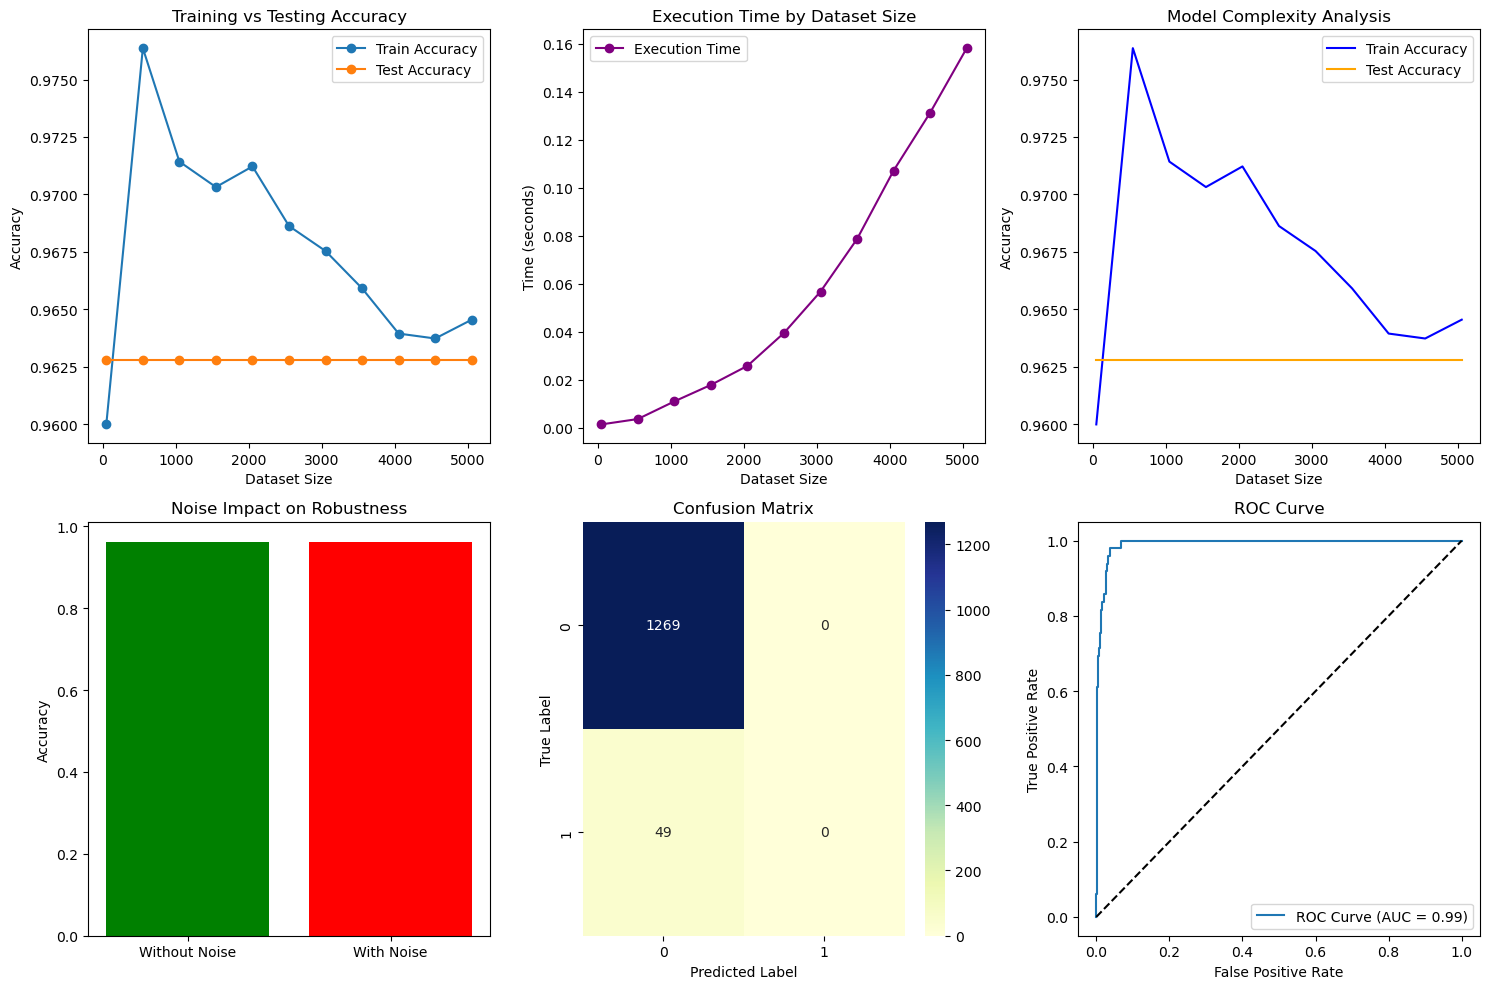

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import time

# Load the dataset
file_path = "maintenance_data.csv"
data = pd.read_csv(file_path)

# Preprocessing
# Drop irrelevant columns
data_cleaned = data.drop(columns=["timestamp", "machine_id"])

# Encode categorical variable
label_encoder = LabelEncoder()
data_cleaned["machine_type"] = label_encoder.fit_transform(data_cleaned["machine_type"])

# Handle missing values
imputer = SimpleImputer(strategy="mean")
data_cleaned.iloc[:, :-1] = imputer.fit_transform(data_cleaned.iloc[:, :-1])

# Separate features and target
X = data_cleaned.iloc[:, :-1]
y = data_cleaned["maintenance_needed"].astype(int)  # Convert target to numeric (True=1, False=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize metrics
train_accuracies = []
test_accuracies = []
execution_times = []
dataset_sizes = []

# SVM Training and Analysis
kernel = "rbf"
for subset_size in range(50, len(X_train), 500):
    X_subset, y_subset = X_train[:subset_size], y_train[:subset_size]
    
    # Measure execution time
    start_time = time.time()
    model = SVC(kernel=kernel, probability=True, random_state=42)
    model.fit(X_subset, y_subset)
    end_time = time.time()
    execution_times.append(end_time - start_time)
    
    # Record dataset size
    dataset_sizes.append(subset_size)
    
    # Measure accuracy
    train_accuracies.append(accuracy_score(y_subset, model.predict(X_subset)))
    test_accuracies.append(accuracy_score(y_test, model.predict(X_test)))

# Final evaluation
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Noise impact analysis
X_test_noisy = X_test + np.random.normal(0, 0.1, X_test.shape)
noise_accuracy = accuracy_score(y_test, model.predict(X_test_noisy))

# Compute ROC curve and AUC
probs = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

# Visualization
plt.figure(figsize=(15, 10))

# 1. Training vs Testing Accuracy
plt.subplot(2, 3, 1)
plt.plot(dataset_sizes, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(dataset_sizes, test_accuracies, label="Test Accuracy", marker="o")
plt.xlabel("Dataset Size")
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy")
plt.legend()

# 2. Execution Time by Dataset Size
plt.subplot(2, 3, 2)
plt.plot(dataset_sizes, execution_times, label="Execution Time", marker="o", color="purple")
plt.xlabel("Dataset Size")
plt.ylabel("Time (seconds)")
plt.title("Execution Time by Dataset Size")
plt.legend()

# 3. Model Complexity Analysis
plt.subplot(2, 3, 3)
plt.plot(dataset_sizes, train_accuracies, label="Train Accuracy", color="blue")
plt.plot(dataset_sizes, test_accuracies, label="Test Accuracy", color="orange")
plt.xlabel("Dataset Size")
plt.ylabel("Accuracy")
plt.title("Model Complexity Analysis")
plt.legend()

# 4. Robustness: Noise Impact
plt.subplot(2, 3, 4)
plt.bar(["Without Noise", "With Noise"], [test_accuracies[-1], noise_accuracy], color=["green", "red"])
plt.title("Noise Impact on Robustness")
plt.ylabel("Accuracy")

# 5. Confusion Matrix
plt.subplot(2, 3, 5)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# 6. ROC Curve
plt.subplot(2, 3, 6)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.tight_layout()
plt.show()
